In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3


######################################################
#===========                             ============#
#===========  Simulation de Trajectoire  ============#
#===========                             ============#
######################################################


# Pas et nombre de points simulés 
h = 10**(-3)
n = 600


U0 = np.array([[10,4,-3],[0.2,0.2,0.1]]) #(vit, pos)
z0 = U0[1,2]

W = 0 # En tr/s
theta = 90 # En ° (angle y,z : 0° -> w=y, 90° -> w=z)
phi = 0 # En ° (angle z,x : 0° -> w=z, 90° -> w=x)
w = 2*np.pi*W*np.array([np.cos(theta*np.pi/180),np.sin(phi*np.pi/180),np.sin(theta*np.pi/180)*np.cos(phi*np.pi/180)])

#Initialisation des listes de positions

X = [U0[1,0]]
Y = [U0[1,1]]
Z = [U0[1,2]]

print('Simulation :',n*h,'s')

Simulation : 0.6 s


In [2]:
#=============== Paramètres de la simulation =============#

alpha = 1.2*(10**(-3))  #Coeff de frottement visqueux 
m = 2.7*(10**(-3))      #Masse Balle
g = 9.81                #Champ gravitationnel
magnus = 1.8*(10**(-4)) #Coeff Magnus 
µ = 0.2526              #Frottement au rebond
r = 2*10**(-2)          #Rayon balle

In [3]:
#=============== Fonctions Utiles ===================#

def vect(u,v):  #Simplifie les expressions (produit vectoriel)
    w = np.zeros(3)
    w[0] = u[1]*v[2]-u[2]*v[1]
    w[1] = u[2]*v[0]-u[0]*v[2]
    w[2] = u[0]*v[1]-u[1]*v[0]
    return w

def f(U,w):     #Fonction pour la méthode d'Euler
    du = U[0,:]
    d2u = -alpha*(np.sqrt(sum(du*du)))*du/m - g*np.array([0,0,1]) + magnus*vect(w,du)
    return np.array([d2u,du])

def norm(a):    #Simplifie également (norme 2)
    n = np.sqrt(sum(a**2))
    return n

def e(vz):      #Coeff de restitution en fonction de Vz
    Vz = abs(vz)
    if Vz<1.9:
        return 0.93
    else:
        return 1 - 0.037*Vz

In [4]:
#=============== Gestion du rebond ====================#

def rebond(U,r,w):  #Fonction qui permet de gérer le rebond
    Vc = U[0,:] + vect(np.array([0,0,r]),w)
    E = e(U[0,2])
    beta = 2.5*µ*(1+E)*abs(U[0,2])/norm(Vc)
    if beta>=1: ###Cas de Roulement
        tau = 0.4       #tau correspond au symbole alpha dans la théorie
        c = (1-tau)/r   # (ou le symbole proportionnel)
        d = tau
    else:       ###Cas de Glissement 
        tau = beta/2.5
        c = 3*tau/(2*r)     
        d = 1 - 3*tau/2
    THETA = np.zeros((6,6))
    A = np.diagflat([1-tau,1-tau,-E])
    B = np.diagflat([tau*r,0],1) + np.diagflat([-tau*r,0],-1)
    C = np.diagflat([-c,0],1) + np.diagflat([c,0],-1)
    D = np.diagflat([d,d,1])
    THETA[0:3,0:3] = A
    THETA[0:3,3:6] = B #A et B sont les mêmes quelque soit beta
    THETA[3:6,0:3] = C #C et D changent d'ou les variables c et d
    THETA[3:6,3:6] = D
    VW = np.zeros(6)
    VW[0:3] = U[0,:] 
    VW[3:6] = w
    VW2 = np.dot(THETA,VW) #Multiplication matricielle
    return VW2 

In [5]:
#================== Simulation =====================#

for p in range(n): #Application de la méthode d'Euler
    U0 = U0 + h*f(U0,w)
    z0 = U0[1,2]
    X.append(U0[1,0])
    Y.append(U0[1,1])
    Z.append(U0[1,2]) #Cas d'un rebond : 
    if z0<10**(-3) and sum(U0[0]*np.array([0,0,1]))<=0: 
        VW = rebond(U0,r,w)
        U0[0,:] = VW[0:3]
        w = VW[3:6]


n = 500
U0[0,:] = np.array([-15,1,1.5])
for p in range(n): #Application de la méthode d'Euler
    U0 = U0 + h*f(U0,w)
    z0 = U0[1,2]
    X.append(U0[1,0])
    Y.append(U0[1,1])
    Z.append(U0[1,2]) #Cas d'un rebond : 
    if z0<10**(-3) and sum(U0[0]*np.array([0,0,1]))<=0: 
        VW = rebond(U0,r,w)
        U0[0,:] = VW[0:3]
        w = VW[3:6]

In [6]:
#########################################################
#===========                                ============#
#===========  Simulation de Trajectoire 2D  ============#
#===========                                ============#
#########################################################

#=============== Fonctions Utiles ================#


def Droite(cam,pt,axis):
    '''
    Simple fonction pour tracer le segment entre un point (pt) et la caméra (cam)
    
    -- Fonction à but uniquement illustratif--
    '''
    t = np.linspace(0,1)

    Droite = np.zeros((3,50))
    Droite[0,:] = cam[0]*t  + (1-t)*pt[0]
    Droite[1,:] = cam[1]*t  + (1-t)*pt[1]
    Droite[2,:] = cam[2]*t  + (1-t)*pt[2]

    axis.plot(Droite[0,:],Droite[1,:],Droite[2,:],'k:')
    return Droite

def pOrtho(M,A,u,v,n=100):
    '''
    Fonction réalisant la projection orthogonale du point M sur le plan (A,u,v) 
    
    -- A, M : points de l'espace 3D --
    -- u, v : Vecteur de l'espace 3D --
    '''
    H = np.zeros(3)
    H[:] = A
    for i in range(n):
        grad = ((sum(u*(M-H))*u) + (sum(v*(M-H))*v))/10
        H += grad
    return H

def pCentrale(M,S,A,u,v):
    '''
    Fonction réalisant la projection centrale du point M sur le plan (A,u,v) par rapport au somment S.
    '''
    P = pOrtho(S,A,u,v)
    Q = pOrtho(S,M,u,v)
    coeff = np.sqrt(sum((P-S)**2)/sum((Q-S)**2))
    H = S + coeff*(M-S)
    return H

def ProjCam(Object,Cam,A,u,v,axis=None,show=False):
    '''
    Fonction projetant tous les points d'un objet (Object) dans le plan ((A,u,v)) de la caméra (Cam).
    
    -- Le plan (A,u,v) désigne l'orientation de la caméra --
    -- Le point Cam désigne uniquement sa position --
    
    %%%%%
    La sortie de cette fonction est la liste des coordonnées des points de Object projetés dans le plan 
    de la caméra. Ce sont donc des coordonnées 3D exprimées dans le même référentiel que les points de 
    Object.
    %%%%%
    '''
    d,n = np.shape(Object)
    Imag = np.zeros((3,n))
    H = pOrtho(Cam,A,u,v)
    if show:
        axis.plot([H[0]],[H[1]],[H[2]],'r+')
    for i in range(n):
        C = pCentrale(Object[:,i],Cam,A,u,v)
        Imag[:,i] = C
        if show:
            Droite(Cam,Table[:,i],axis)
            axis.plot([C[0]],[C[1]],[C[2]],'ko')
    return Imag

def RefChg(Data,O,u,v,show=False):
    '''
    Effectue le changement de repère 3D --> 2D.
    
    Data : Jeu de données en 3D 
    Plan (O,u,v) : Référentiel (2D) dans lequel on projette les données de Data
    
    %%%%%
    La sortie de cette fonction est la liste des coordonnées en 2D dans le référentiel ((O,u,v)), avec 
    O l'origine du repère
    '''
    d,n = np.shape(Data)
    Ruv = np.zeros((2,n))
    if show:
        figRuv, axRuv = plt.subplots()
    
    for i in range(n):
        Ruv[0,i] = sum(u*(Data[:,i]-O))
        Ruv[1,i] = sum(v*(Data[:,i]-O))
        if show:
            axRuv.plot([Ruv[0,i]],[Ruv[1,i]],'bo')
    if show:
        axRuv.plot(Ruv[0,:],Ruv[1,:],'k--')
        axRuv.plot([0],[0],'r+')
        axRuv.axis('equal')
    return Ruv

In [7]:
#=============== Dimensionnement de la Table ================#
    
L = 2.74
l = 1.522
H = 0.1525

Table = np.array([[0,0,L,L,0,0  ,L  ,L ,L/2,L/2,L/2,L/2,L/2],
				  [0,l,l,0,0,l/2,l/2,0 ,0  ,0  ,l  ,l  ,0],
				  [0,0,0,0,0,0  ,0  ,0 ,0  ,H  ,H  ,0  ,0]])

Table (3, 13)
Traj (3, 1101)
New Ref (2, 1114)
Fps = 25.0


/Users/yanisfilippi/ANACONDA_LastV/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


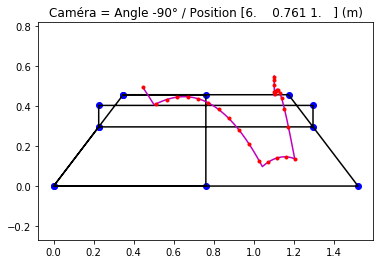

In [8]:
#=============== Trajectoire simulée ================#    
Traj = np.zeros((3,len(X)))
Traj[0,:] = X
Traj[1,:] = Y
Traj[2,:] = Z

d1, n1 = np.shape(Table)
d2, n2 = np.shape(Traj)
print('Table',(d1,n1))
print('Traj',(d2,n2))

Data = np.zeros((3,n1+n2))

Data[:,0:n1] = Table
Data[:,n1:n1+n2] = Traj

Cam = np.array([6.00,l/2,1.00])

Theta = -90 #(°)
u = np.array([np.cos(Theta*np.pi/180),0,np.sin(Theta*np.pi/180)])
v = np.array([0,1,0])



A = Table[:,2]
I = ProjCam(Data,Cam,A,u,v)
H = pOrtho(Cam,A,u,v)
R = RefChg(I,I[:,3],v,-u)

print('New Ref',np.shape(R))
fig2, ax2 = plt.subplots()

p = 40
print('Fps =',1/(p*h))
Test = np.zeros((2,n2//p + 1))
for i in range(n2):
    if i%p==0:
        Test[:,i//p] = R[:,n1+i]


ax2.plot(R[0,0:n1],R[1,0:n1],'bo')
ax2.plot(R[0,0:n1],R[1,0:n1],'k-')
ax2.plot(R[0,n1:n1+n2],R[1,n1:n1+n2],'m-')
ax2.plot(Test[0,:],Test[1,:],'r.')
ax2.axis('equal')
ax2.set_title('Caméra = Angle {}° / Position {} (m)'.format(Theta,Cam))
fig2.show()

/Users/yanisfilippi/ANACONDA_LastV/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


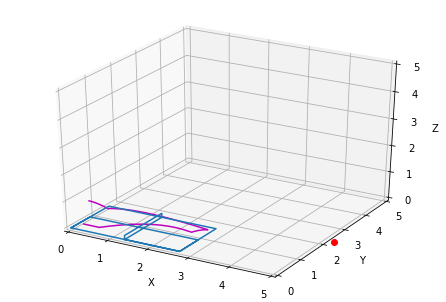

In [9]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.plot(X,Y,Z,'m-')
#ax.set_xlabel('X')
#ax.set_xlim3d([-1,1])
#ax.set_ylabel('Y')
#ax.set_ylim3d([0,2])
#ax.set_zlabel('Z')
#ax.set_zlim3d([-0.2,1])
ax.set_xlabel('X')
ax.set_xlim3d([0,5])
ax.set_ylabel('Y')
ax.set_ylim3d([0,5])
ax.set_zlabel('Z')
ax.set_zlim3d([0,5])
ax.plot(Table[0,:],Table[1,:],Table[2,:])
ax.plot([Cam[0]],[Cam[1]],[Cam[2]],'ro')
fig.show()
